# Feature analysis

Feature analysis from eICU-CRD and MIMIC-III observations.

In [1]:
import aidxmods as axm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
mixed = axm.get().records
eicu = axm.get(dbname='eicu').records
mimic = axm.get(dbname='mimic').records

# Quantile settings
q100 = [x / 100 for x in range(0, 101)]
q1000 = [x / 1000 for x in range(0, 1001)]

# Features composition
full_features = axm.Fitter.features
full_features = full_features.sort_values(
    ['numeric', 'missingFlag'], 
    ascending=[False, True]
)
features_length = len(full_features)

numeric_var = full_features[full_features['numeric'] == 1].index
binary_var = full_features[full_features['numeric'] == 0].index
flags_var = full_features[full_features['missingFlag'] == 1].index

# Distributions

Q-Q plots are displayed for numeric variables to compare their distribution. For binary variables, barplots are showed.

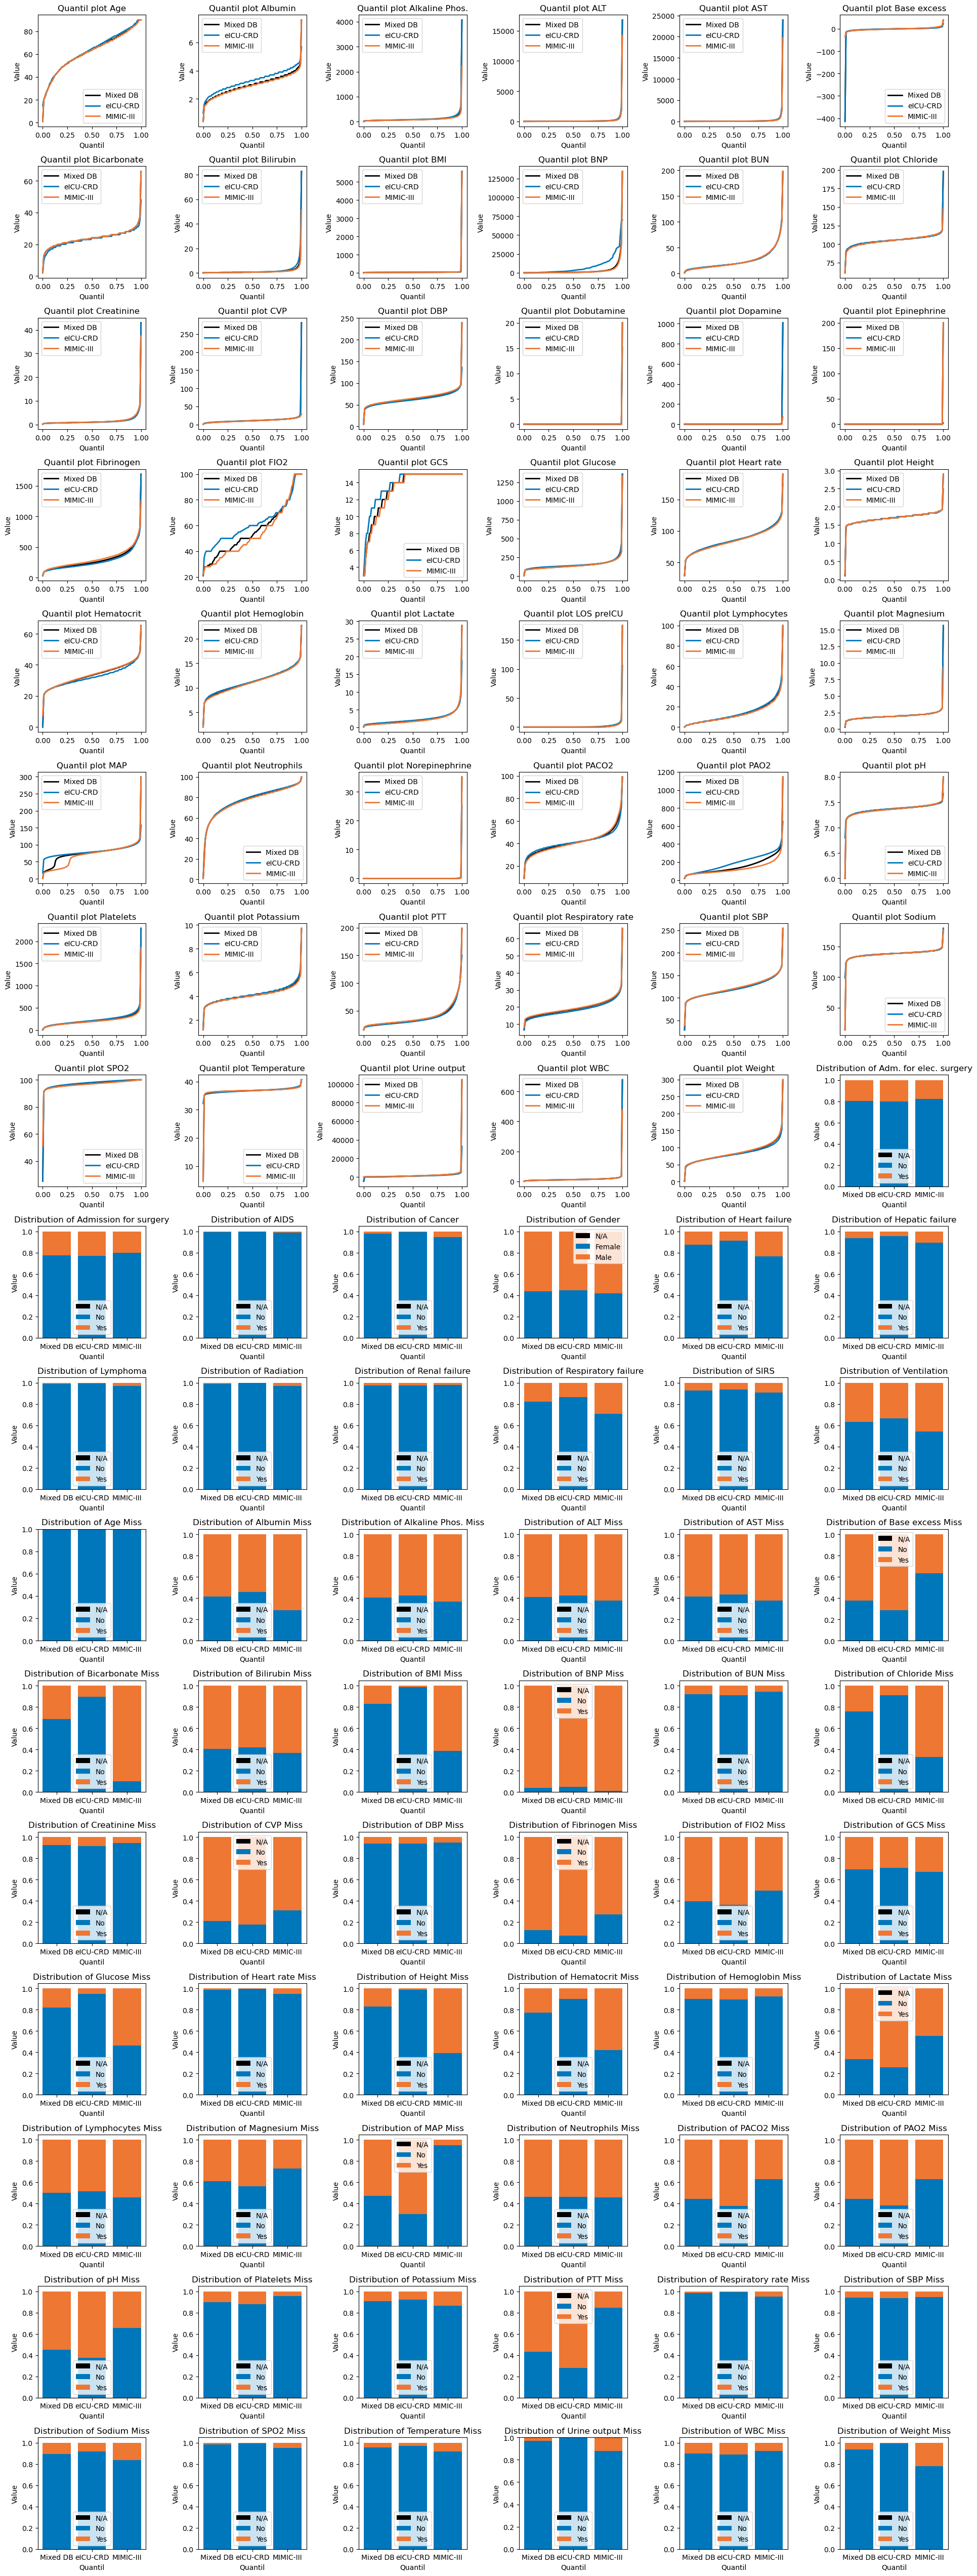

In [3]:
cols = 6
rows = features_length // cols

fig, axs = axm.setfig(rows, cols, figsize=(19, 0.5 * features_length), theme='color')

for i, feature in enumerate(full_features.index):
    
    labels = ['Mixed DB', 'eICU-CRD', 'MIMIC-III']
    bar_labels = ['N/A', 'Female', 'Male'] if feature == 'Gender' else ['N/A', 'No', 'Yes']
    row = i // cols
    col = i % cols
    
    # Get stats
    varmixed = mixed[feature]
    vareicu = eicu[feature]
    varmimic = mimic[feature]
       
    # Quantil distribution
    if feature in numeric_var:
        axs[row, col].plot(varmixed.quantile(q100))
        axs[row, col].plot(varmimic.quantile(q100))
        axs[row, col].plot(vareicu.quantile(q100))
        axs[row, col].set_title('Quantil plot ' + feature)
        axs[row, col].set_xlabel('Quantil')
        axs[row, col].set_ylabel('Value')
        
        axs[row, col].legend(labels)
    
    elif feature in binary_var:
        
        # Missing data
        groupsna = [
            1 - varmixed.count() / len(varmixed),
            1 - vareicu.count() / len(vareicu),
            1 - varmimic.count() / len(varmimic),
        ]
        axs[row, col].bar(labels, groupsna)
        
        # Data encoded as Zero
        groups0 = [
            varmixed[varmixed == 0].count() / len(varmixed),
            vareicu[vareicu == 0].count() / len(vareicu),
            varmimic[varmimic == 0].count() / len(varmimic),
        ]
        axs[row, col].bar(labels, groups0, bottom=groupsna)
        
        # Data encoded as One (Non-zero for dop, epi, norepi, dobu)
        groups1 = [
            varmixed[varmixed != 0].count() / len(varmixed),
            vareicu[vareicu != 0].count() / len(vareicu),
            varmimic[varmimic != 0].count() / len(varmimic),
        ]
        axs[row, col].bar(labels, groups1, bottom=[groupsna[i] + groups0[i] for i in range(0, len(groups1))])
        
        axs[row, col].set_title('Distribution of ' + feature)
        axs[row, col].set_xlabel('Quantil')
        axs[row, col].set_ylabel('Value')

        axs[row, col].legend(bar_labels)

axm.handlefig('1-database-distr')

# Missing rates

To explore the missing rates of the variables, we count for each patient the number the variables that are missing, and ordered them by quantiles.

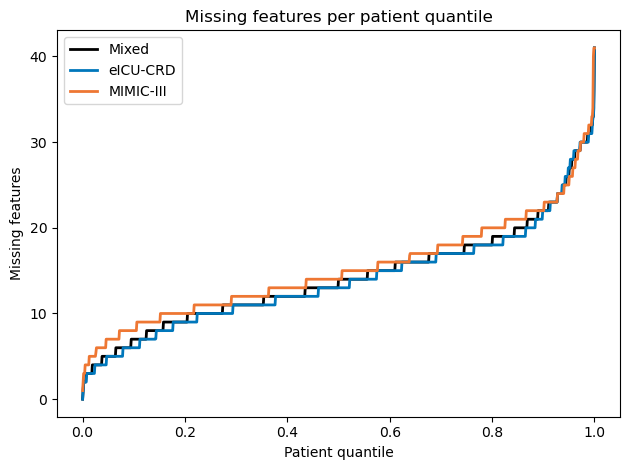


Missing rates (%) by feature
                       Mixed  eICU-CRD  MIMIC-III
Age Miss                0.00      0.00       0.00
Heart rate Miss         1.43      0.17       4.90
SPO2 Miss               1.64      0.39       5.10
Respiratory rate Miss   1.75      0.54       5.11
Urine output Miss       3.24      0.00      12.24
Temperature Miss        4.38      3.03       8.11
DBP Miss                5.90      6.15       5.20
SBP Miss                5.90      6.16       5.20
Weight Miss             6.25      0.59      21.96
Creatinine Miss         7.67      8.34       5.80
BUN Miss                8.01      8.78       5.87
Potassium Miss          9.22      7.67      13.51
Hemoglobin Miss         9.67     10.41       7.62
Platelets Miss         10.05     12.07       4.47
WBC Miss               10.25     11.20       7.61
Sodium Miss            10.47      8.42      16.18
Height Miss            16.99      1.14      60.98
BMI Miss               17.26      1.44      61.17
Glucose Miss        

In [4]:
# Quantile distribution of variables missing per patient
mixed_pat_miss = mixed[flags_var].sum(axis=1)
mixed_q_pat_miss = mixed_pat_miss.quantile(q1000)

eicu_pat_miss = eicu[flags_var].sum(axis=1)
eicu_q_pat_miss = eicu_pat_miss.quantile(q1000)

mimic_pat_miss = mimic[flags_var].sum(axis=1)
mimic_q_pat_miss = mimic_pat_miss.quantile(q1000)

fig, axs = axm.setfig(theme='color')
axs.plot(mixed_q_pat_miss, label="Mixed")
axs.plot(eicu_q_pat_miss, label="eICU-CRD")
axs.plot(mimic_q_pat_miss, label="MIMIC-III")
axs.set_xlabel('Patient quantile')
axs.set_ylabel('Missing features')
axs.set_title('Missing features per patient quantile')
plt.legend()
axm.handlefig('1-quantile-missing')

# Calculate missing rates of subgroups
mixed_mr = mixed[flags_var].mean() * 100
mixed_mr.name = 'Mixed'
eicu_mr = eicu[flags_var].mean() * 100
eicu_mr.name = 'eICU-CRD'
mimic_mr = mimic[flags_var].mean() * 100
mimic_mr.name = 'MIMIC-III'

missing_rates = pd.concat([mixed_mr, eicu_mr, mimic_mr], axis=1)
missing_rates = missing_rates.sort_values(by='Mixed')

print('\nMissing rates (%) by feature')
print(missing_rates.round(2))

# Correlations

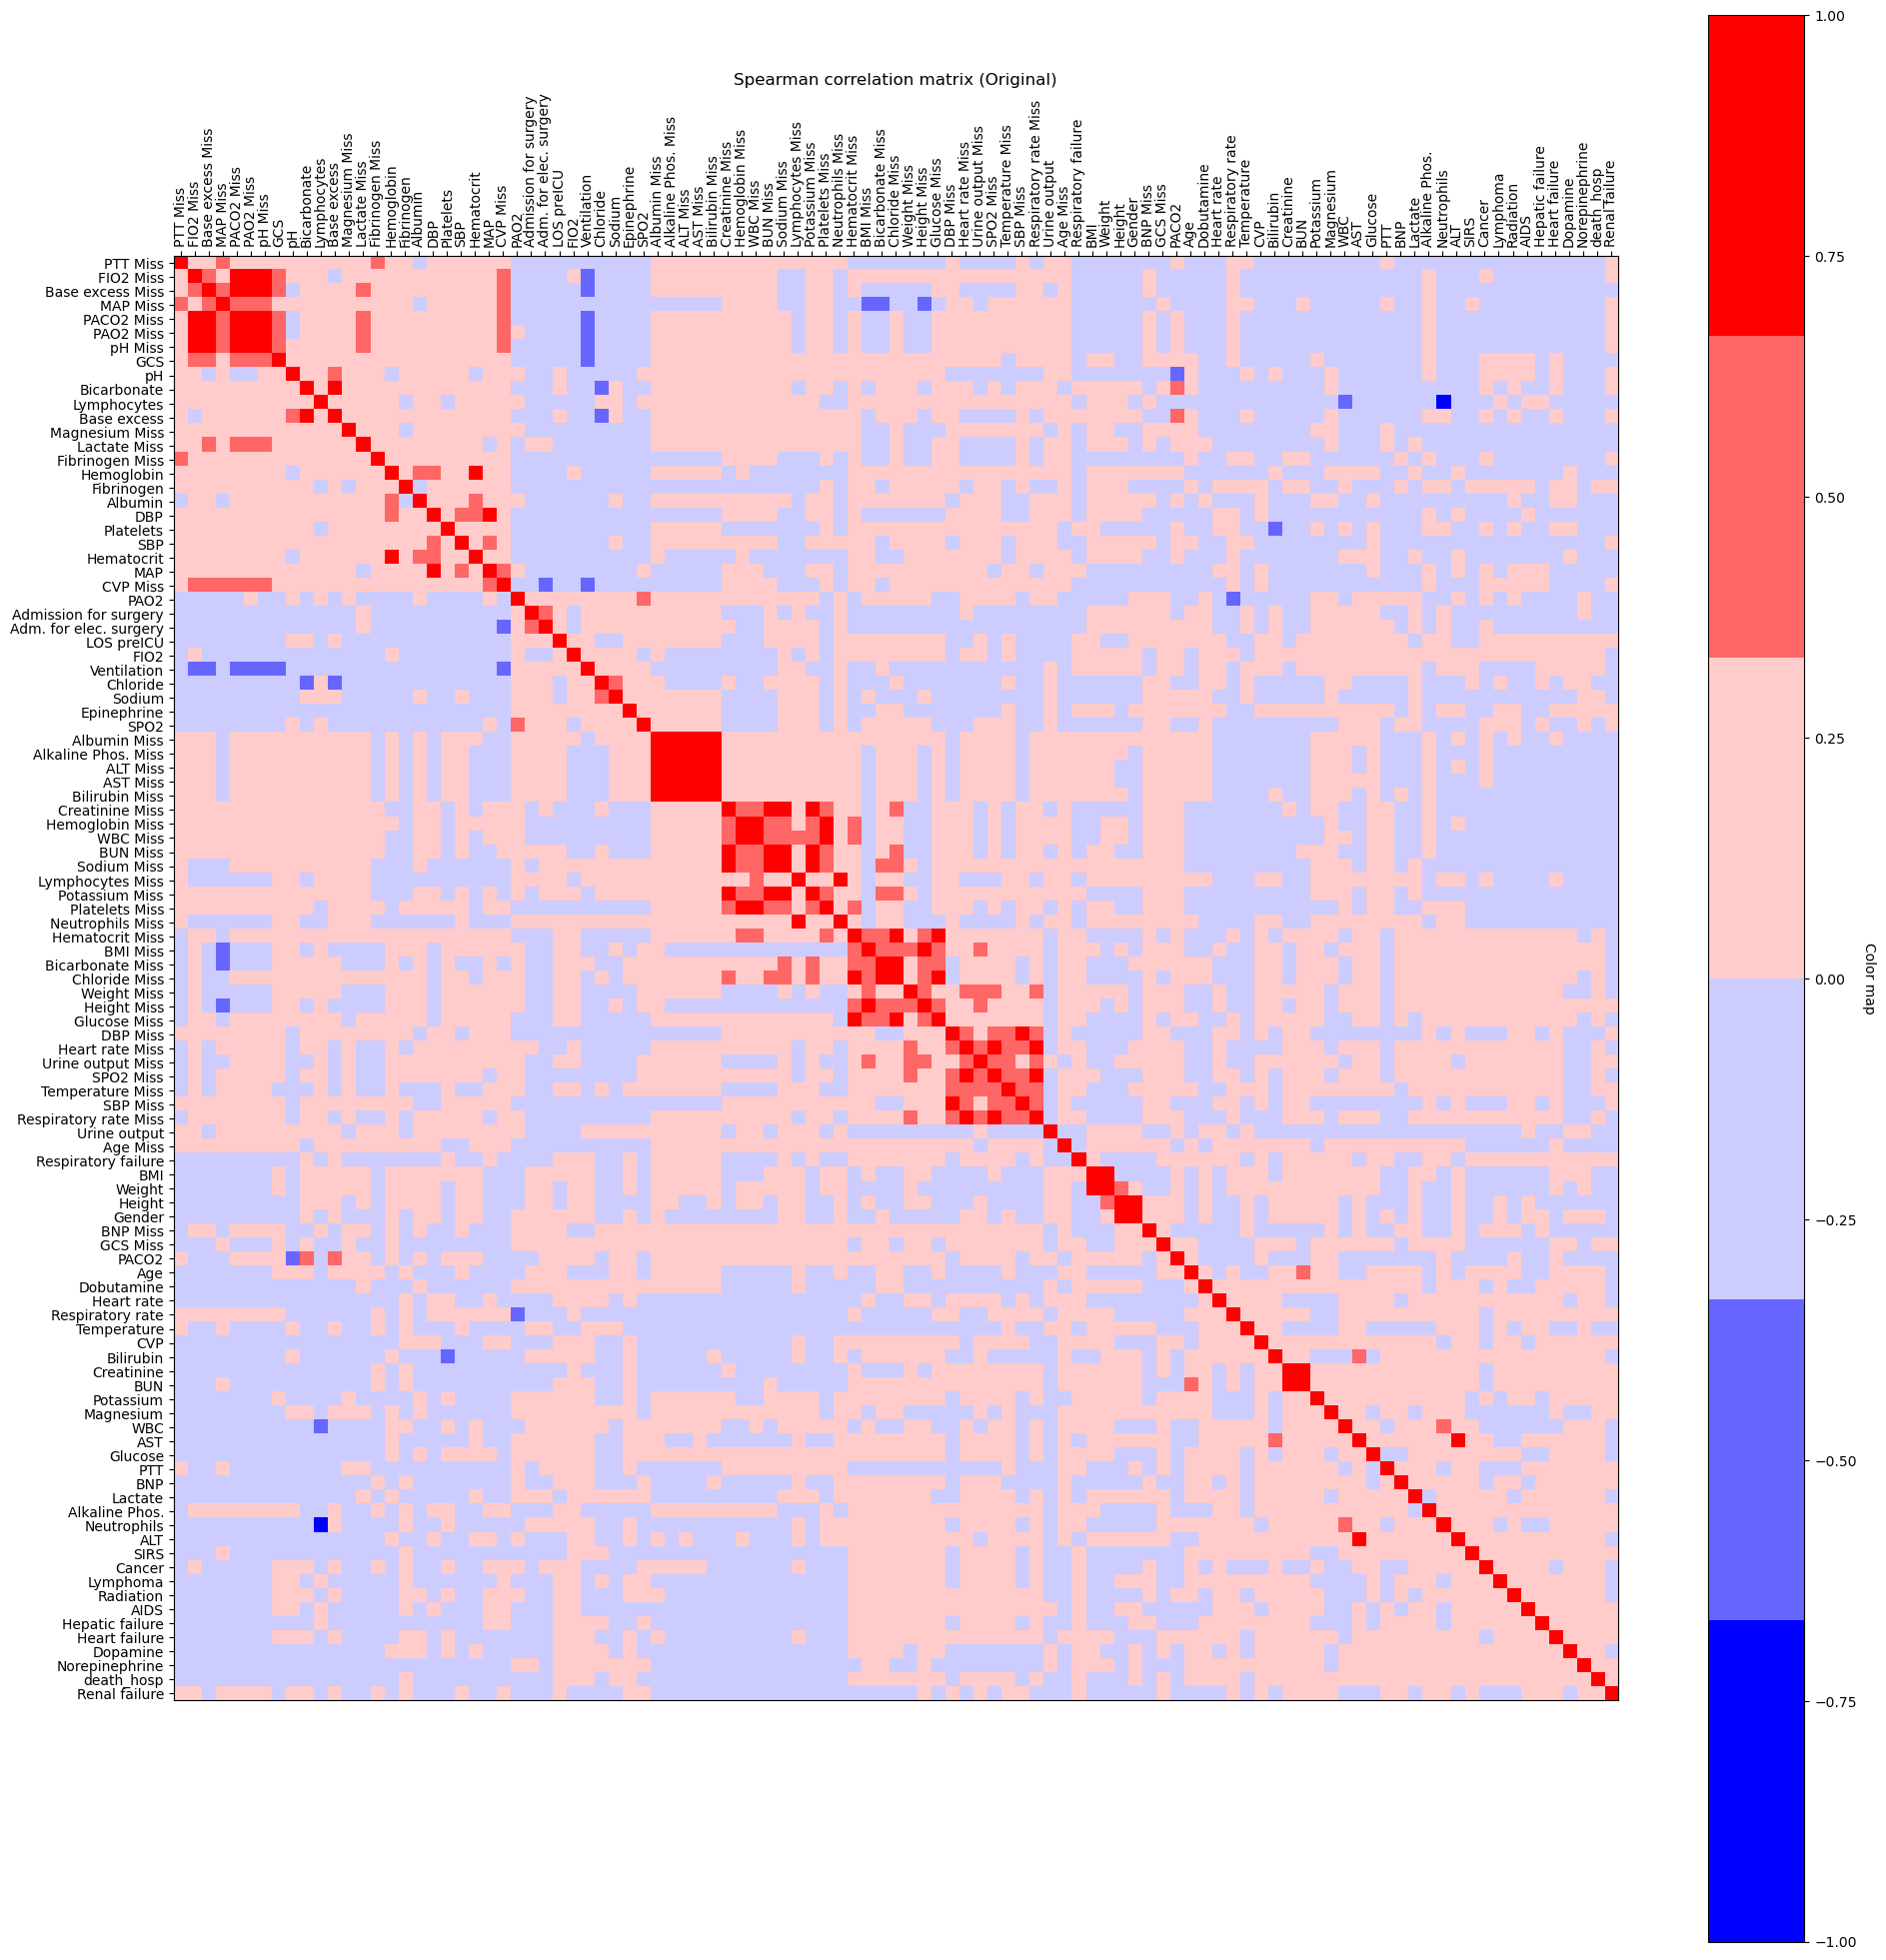

              FIO2 Miss - +0.703 - PACO2 Miss             
              FIO2 Miss - +0.707 - PAO2 Miss              
              FIO2 Miss - +0.690 - pH Miss                
       Base excess Miss - +0.854 - PACO2 Miss             
       Base excess Miss - +0.855 - PAO2 Miss              
       Base excess Miss - +0.855 - pH Miss                
             PACO2 Miss - +0.991 - PAO2 Miss              
             PACO2 Miss - +0.968 - pH Miss                
              PAO2 Miss - +0.974 - pH Miss                
            Bicarbonate - +0.894 - Base excess            
            Lymphocytes - -0.798 - Neutrophils            
             Hemoglobin - +0.956 - Hematocrit             
                    DBP - +0.731 - MAP                    
           Albumin Miss - +0.852 - Alkaline Phos. Miss    
           Albumin Miss - +0.851 - ALT Miss               
           Albumin Miss - +0.850 - AST Miss               
           Albumin Miss - +0.845 - Bilirubin Miss       

In [5]:
# Separate features from outputs
x_series = mixed.drop('death_hosp', axis=1)
y_series = mixed['death_hosp']

# Calculate correlations and covariances
spearman_corr = axm.cluster_matrix(mixed.corr(method='spearman').fillna(0))

axm.plot_matrix(spearman_corr, 'Spearman correlation matrix (Original)', '1-spearman-corr')

# Print more correlated features
threshold = 2 / 3
parsed = []
for f1, corr1 in spearman_corr.items():
    
    parsed.append(f1)
    corr1 = corr1.drop(parsed)
    
    for f2, corr2 in corr1.items():
        upperlim = corr2 > threshold
        lowerlim = corr2 < - threshold
        samename = f1 == f2
        
        if (upperlim or lowerlim) and not samename:
            print(f'{f1:>23} - {corr2:+.3f} - {f2:<23}')

# Splitting method

In [6]:
voyager = axm.get(name='voyager').split()

In [7]:
len(voyager.xtrain), len(voyager.xtrain) / len(voyager.records)

(65880, 0.5880935165100024)

In [8]:
len(voyager.xtest), len(voyager.xtest) / len(voyager.records)

(16471, 0.14703230586575972)

In [9]:
len(voyager.xval), len(voyager.xval) / len(voyager.records)

(29672, 0.26487417762423787)

# Imputed distrubutions

Exploration of the imputed distribution of certain variables of interest.

In [ ]:
# Impute missing data. Imputed training data is located in fitter.itrain
# and imputed test data is located in fitter.itest
fitter = axm.get().preprocess()
notimputed = pd.concat([fitter.xtrain, fitter.xtest])
imputed = pd.concat([fitter.itrain, fitter.itest])

## Lactate

In [ ]:
lactate_combined = imputed['Lactate']
lactate_pmmimp = imputed.loc[imputed['Lactate Miss'] == 1, 'Lactate']
lactate_noimp = notimputed.loc[notimputed['Lactate Miss'] == 0, 'Lactate']

fig, ax = axm.setfig(figsize=(4, 3), theme='color')
ax.plot(lactate_combined.quantile(q100), label='Imputed data')
ax.plot(lactate_pmmimp.quantile(q100), label='Only PMM imputation')
ax.plot(lactate_noimp.quantile(q100), label='Only No imputation')
ax.set_title('Lactate quantile plot')
ax.legend()
plt.show()

## FIO2

In [ ]:
fio2_combined = imputed['FIO2']
fio2_pmmimp = imputed.loc[imputed['FIO2 Miss'] == 1, 'FIO2']
fio2_noimp = notimputed.loc[notimputed['FIO2 Miss'] == 0, 'FIO2']

fig, ax = axm.setfig(figsize=(4, 3), theme='color')
ax.plot(fio2_combined.quantile(q100), label='Imputed data')
ax.plot(fio2_pmmimp.quantile(q100), label='Only PMM imputation')
ax.plot(fio2_noimp.quantile(q100), label='Only No imputation')
ax.set_title('FIO2 quantile plot')
ax.legend()
plt.show()

## BNP

In [ ]:
records = notimputed.copy()
missing_bnp = records['BNP'].isna()
sex = records.loc[missing_bnp]['Gender']
age = records.loc[missing_bnp]['Age']
bnp = records.loc[missing_bnp]['BNP']

records.loc[(sex == 1) & (age < 60) & missing_bnp, 'BNP'] = 4.9 * 3.4641
records.loc[(sex == 0) & (age < 60) & missing_bnp, 'BNP'] = 4.1 * 3.4641

records.loc[(sex == 1) & (60 <= age) & (age < 70) & missing_bnp, 'BNP'] = 14.4 * 3.4641
records.loc[(sex == 0) & (60 <= age) & (age < 70) & missing_bnp, 'BNP'] = 10.2 * 3.4641

records.loc[(sex == 1) & (70 <= age) & (age < 80) & missing_bnp, 'BNP'] = 31.7 * 3.4641
records.loc[(sex == 0) & (70 <= age) & (age < 80) & missing_bnp, 'BNP'] = 25.2 * 3.4641

records.loc[(sex == 1) & (age >= 80) & missing_bnp, 'BNP'] = 53.3 * 3.4641
records.loc[(sex == 0) & (age >= 80) & missing_bnp, 'BNP'] = 46.0 * 3.4641

bnp_combined = imputed['BNP']
bnp_manimp = records.loc[records['BNP Miss'] == 1, 'BNP']
bnp_pmmimp = imputed.loc[imputed['BNP Miss'] == 1, 'BNP']
bnp_noimp = notimputed.loc[notimputed['BNP Miss'] == 0, 'BNP']

fig, ax = axm.setfig(figsize=(4, 3), theme='color')
ax.plot(bnp_combined.quantile(q100), label='Imputed data')
ax.plot(bnp_manimp.quantile(q100), label='Only Manual imputation')
ax.plot(bnp_pmmimp.quantile(q100), label='Only PMM imputation')
ax.plot(bnp_noimp.quantile(q100), label='Only No imputation')
ax.set_title('BNP quantile plot')
ax.legend()
plt.show()

# Summary

In [ ]:
fitter = axm.get().split()
not_missing_flags = fitter.get_features('!missingFlag', 'enabledToFit')
records = fitter.records[not_missing_flags]
training = fitter.xtrain[not_missing_flags]
testing = fitter.xtest[not_missing_flags]
validation = fitter.xval[not_missing_flags]

In [ ]:
pd.set_option('display.max_rows', None)
summary_preds = pd.DataFrame({
    ( 'eICU-CRD (Training)', '1%'): training.quantile(0.01),
    ( 'eICU-CRD (Training)', '50%'): training.quantile(0.50),
    ( 'eICU-CRD (Training)', '99%'): training.quantile(0.99),
    ( 'eICU-CRD (Training)', 'Mean'): training.mean(),
    ( 'eICU-CRD (Test)', '1%'): testing.quantile(0.01),
    ( 'eICU-CRD (Test)', '50%'): testing.quantile(0.50),
    ( 'eICU-CRD (Test)', '99%'): testing.quantile(0.99),
    ( 'eICU-CRD (Test)', 'Mean'): testing.mean(),
    ('MIMIC-III (Validation)', '1%'): validation.quantile(0.01),
    ('MIMIC-III (Validation)', '50%'): validation.quantile(0.50),
    ('MIMIC-III (Validation)', '99%'): validation.quantile(0.99),
    ( 'MIMIC-III (Validation)', 'Mean'): validation.mean(),
}).round(2).sort_index()
summary_preds.to_csv('data/summary-predictors.csv')
summary_preds

In [ ]:
pd.set_option('display.max_rows', None)
summary_miss = pd.DataFrame({
    (  'Missing rate (%)', 'Training'): (100 - (training.count() / len(training)) * 100).round(2),
    (  'Missing rate (%)', 'Testing'): (100 - (testing.count() / len(testing)) * 100).round(2),
    (  'Missing rate (%)', 'Validation'): (100 - (validation.count() / len(validation)) * 100).round(2),
    (  'Missing rate (%)', 'Overall'): (100 - (records.count() / len(records)) * 100).round(2),
}).round(2).sort_index()
summary_miss.to_csv('data/summary-missing.csv')
summary_miss

In [ ]:
survivors1 = pd.concat([training[fitter.ytrain == 0], testing[fitter.ytest == 0]])
nonsurvivors1 = pd.concat([training[fitter.ytrain == 1], testing[fitter.ytest == 1]])
survivors2 = validation[fitter.yval == 0]
nonsurvivors2 = validation[fitter.yval == 1]

In [ ]:
pd.set_option('display.max_rows', None)
summary_class = pd.DataFrame({
    (  'eICU-CRD (training and test)', 'Survivor'): survivors1.mean(),
    (  'eICU-CRD (training and test)', 'Non-survivor'): nonsurvivors1.mean(),
    (  'MIMIC-III (validation)', 'Survivor'): survivors2.mean(),
    (  'MIMIC-III (validation)', 'non-survivor'): nonsurvivors2.mean(),
}).round(2).sort_index()

import scipy.stats as stats
print_pvalue = lambda pvalue: f'{pvalue:.3f}' if pvalue >= 0.001 else '< 0.001'

for col in summary_class.index:
    a = survivors1[col]
    b = nonsurvivors1[col]
    c = survivors2[col]
    d = nonsurvivors2[col]
    ttest_ab = stats.ttest_ind(a, b, equal_var=False, alternative='two-sided', nan_policy='omit').pvalue
    ttest_cd = stats.ttest_ind(c, d, equal_var=False, alternative='two-sided', nan_policy='omit').pvalue
    summary_class.loc[col, ('eICU-CRD (training and test)', 'p-value')] = print_pvalue(ttest_ab)
    summary_class.loc[col, ('MIMIC-III (validation)', 'p-value')] = print_pvalue(ttest_cd)

summary_class.to_csv('data/summary-classes.csv')
summary_class

In [ ]:
print(f'Training mortality: {fitter.ytrain.sum():,} ({(fitter.ytrain.mean()):.2%})')
print(f'Test mortality: {fitter.ytest.sum():,} ({(fitter.ytest.mean()):.2%})')
print(f'Validation mortality: {fitter.yval.sum():,} ({(fitter.yval.mean()):.2%})')